In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sys
sys.path.append('./zdrojaky')
from tsplot import tsplot
from statsmodels import tsa
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.api import qqplot
from IPython.display import display, Markdown
from statsmodels.tsa.seasonal import seasonal_decompose

# Four-weekly totals of beer shipments
Čtyřtýdení součty objednávek piva. Rok neznámý, proto jako pravděpodobný rok byl zvolen rok 1970.

In [3]:
df = pd.read_csv('fourweekly-totals-of-beer-shipme.csv')
df.info()

fn = 'fourweekly-totals-of-beer-shipme.csv'
# Vyberu z datasetu pouze součtu objednávek v jednotlivých týdnech
data = df['Four-weekly totals of beer shipments'].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 2 columns):
Week                                    52 non-null object
Four-weekly totals of beer shipments    52 non-null int64
dtypes: int64(1), object(1)
memory usage: 912.0+ bytes


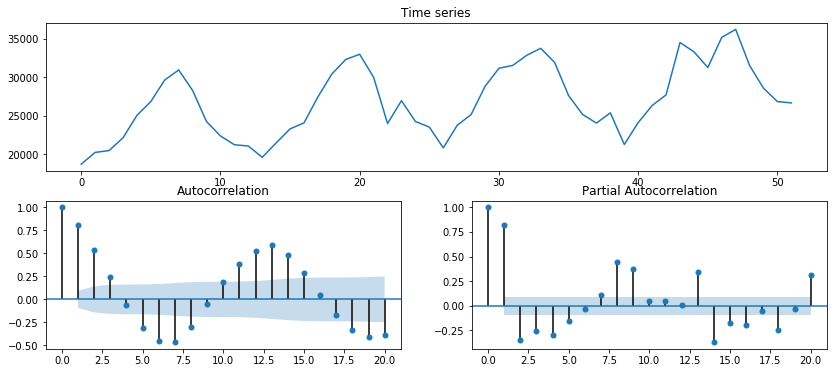

In [4]:
tsplot(data)

Časová řada představuje prodeje piva za 4 roky vždy po čtyřtýdenních součtech.
Při pohledu na časovou řadu je patrná sezónost, která se dala očekávat.
Nárůst objednávek přes letní měsíce, kdy se určitě více pije pivo.

Dále méně patrný je trend. V těchto 4 letech počet objednávek narůstal.
Může být výhodné si vyzkoušet řadu dekomponovat na trend, sezónost a šum.

Z vizualizace je patrná perioda, která je 13 (52/4). Jeden rok, ale převeden na reprezentaci v datech, tedy čtyřtýdenní součty.

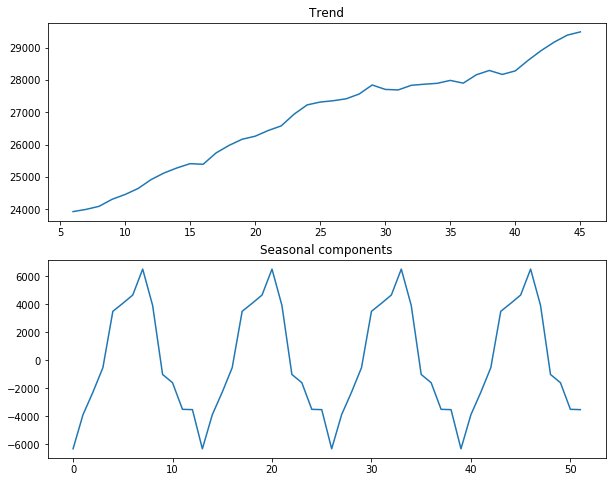

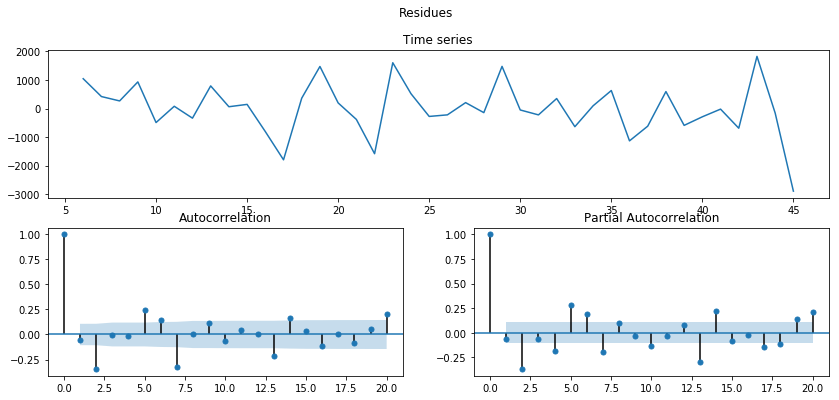

In [30]:
result = seasonal_decompose(df['Four-weekly totals of beer shipments'], freq=13, model='aditive')
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(result.trend)
plt.title("Trend")
plt.subplot(2,1,2)
plt.plot(result.seasonal)
plt.title("Seasonal components")
tsplot(result.resid.dropna())
plt.suptitle("Residues")
plt.show()

Zde je vidět patrný předpokládaný trend a sezónost. V reziduích však mohou stále zůstavát některé nevysvětlené části. 

Budu se snažit na řadu nafitovat model, který z těchto poznatků zvolím SARIMAX se sezónou popsanou výše. S jednou differencí pro sezóní paramentry.

                            Statespace Model Results                            
Dep. Variable:                        y   No. Observations:                   52
Model:             SARIMAX(0, 1, 0, 13)   Log Likelihood                -359.472
Date:                  Tue, 18 Dec 2018   AIC                            720.943
Time:                          19:14:10   BIC                            722.607
Sample:                               0   HQIC                           721.540
                                   - 52                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.859e+06   1.83e+06      3.197      0.001    2.27e+06    9.45e+06
Ljung-Box (Q):                       38.12   Jarque-Bera (JB):                 0.76
Prob(Q):                       

<Figure size 1080x216 with 0 Axes>

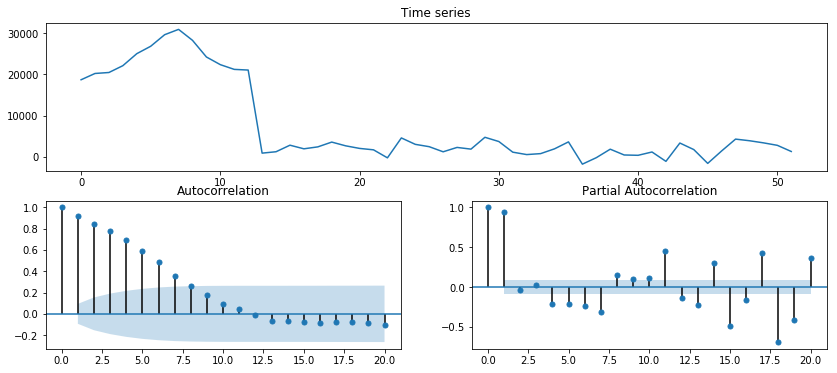

In [41]:
model = SARIMAX(data, order=(0,0,0), seasonal_order=(0,1,0,13))
result = model.fit()
print(result.summary())
plt.figure(figsize=(15,3))
tsplot(result.resid)
plt.show()

Z PACF je ještě stále vysoký první peak, který může signalizovat AR složku nebo poddifferencovanost modelu. 

Podle toho jak je velmi vysoký, proto v modelu zvýším differenci o 1. 
(Při vyzkoušení navýšení koeficientu AR, 
 vyšla pro první parametr p-hondota rovna nule tedy staticsticky významná, 
 ale v reziduích zůstal v PACF stále velký první peak. Také se snížila hodnota BIC a AIC)

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   52
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 13)   Log Likelihood                -343.405
Date:                            Tue, 18 Dec 2018   AIC                            688.811
Time:                                    19:24:56   BIC                            690.448
Sample:                                         0   HQIC                           689.393
                                             - 52                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.077e+06   8.21e+05      4.969      0.000    2.47e+06    5.69e+06
Ljung-Box (Q):                     

<Figure size 1080x216 with 0 Axes>

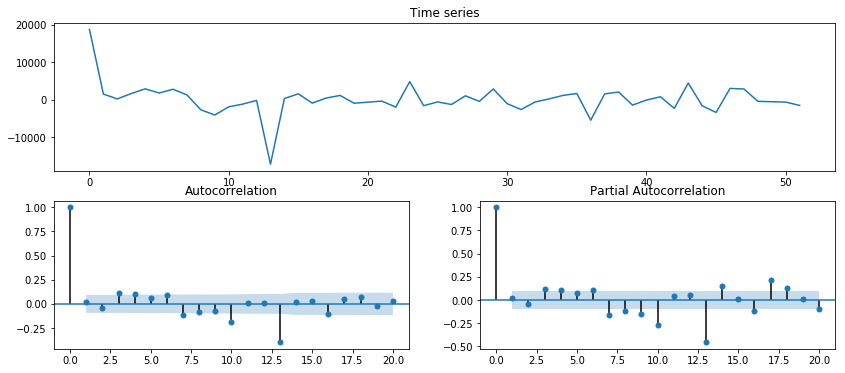

In [51]:
model = SARIMAX(data, order=(0,1,0), seasonal_order=(0,1,0,13))
result = model.fit()
print(result.summary())
plt.figure(figsize=(15,3))
tsplot(result.resid)
plt.show()

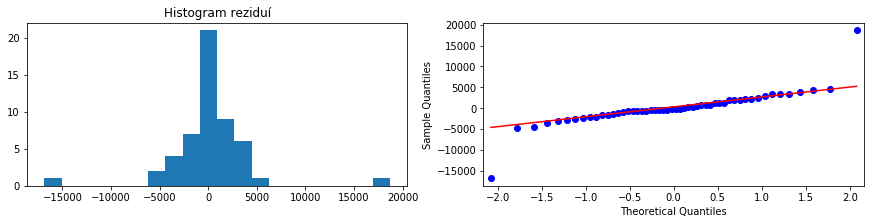

In [16]:
plt.figure(figsize=(15,3))
ax = plt.subplot(1,2,1)
plt.hist(result.resid, bins=20)
plt.title('Histogram reziduí')
ax = plt.subplot(1,2,2)
qqplot(result.resid, line='q', ax=ax)
plt.show()

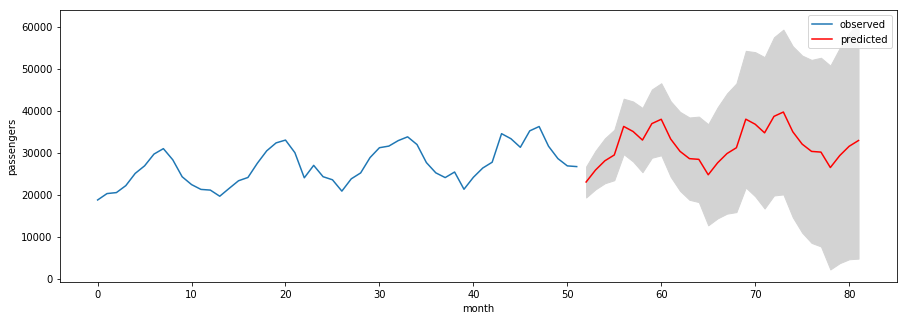

In [17]:
nsteps = 30
forecast = result.get_forecast(steps=nsteps)
plt.figure(figsize=(15,5))
plt.plot(np.arange(data.size), data, label='observed')
plt.plot(np.arange(data.size, data.size+forecast.predicted_mean.size), 
         forecast.predicted_mean, 'r', label='predicted')
plt.fill_between(np.arange(data.size, data.size+forecast.predicted_mean.size), 
                 forecast.summary_frame()['mean_ci_lower'],
                 forecast.summary_frame()['mean_ci_upper'],
                 color='lightgray')
plt.legend()
plt.xlabel('month')
plt.ylabel('passengers')
plt.show()

Zdroj dat: <https://datamarket.com/data/set/2325/four-weekly-totals-of-beer-shipments#!ds=2325&display=line>